# Custom Function to Turn Points, Linestrings, Polygons Shapes to Indicies #

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import rasterio.mask
import rasterio.plot
import requests
import folium
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
from pathlib import Path
from rasterio.features import rasterize
from rasterio.plot import show
import seaborn as sns
from scipy.ndimage import distance_transform_edt
import xarray as xr
from rasterio.transform import from_origin


# Read in Kenya Data #

In [48]:
# Bulding Density Data
building_density_path = '/mnt/team/rapidresponse/pub/population/data/03-processed-data/building-layers/KEN/2020_q2/full.tif'
with rasterio.open(building_density_path) as src:
    # We don't need anything from this dataset except the metadata about 
    # it's shape and resolution.
    meta = src.meta
    kenya_shape = src.shape
    
# Transform Data
target_transform = meta['transform']
# Out metadata is exactly the same as our in metadata.
out_meta = meta.copy()
target_crs = out_meta['crs']

# Resolution Data
resolution = target_transform.a  # You can access matrix elements by a,b,c,d,etc, just check you're getting the value you expect.
x_offset = target_transform.xoff
y_offset = target_transform.yoff

# Get the width and height in pixels from the metadata
target_width = meta['width']
target_height = meta['height']

# Make arrays of [0, 1, ..., width] and [0, 1, ..., height]
x_ind = np.arange(target_width)  # Just like python's `range` function, but makes a numpy array, which we can do vector math with.
y_ind = np.arange(target_height) 

# Here is the magic of numpy. We can write the same expressions and they'll
# work pretty much seamlessly across scalars and vectors and higher dimensional arrays
# (as long as the operations are well defined.
x = resolution * (x_ind + 1/2) + x_offset  # Makes an array where each element is now an x-coordinate of a centroid in our CRS
y = -resolution * (y_ind + 1/2) + y_offset

# Custom Distance Algorithm #

In [49]:
from numba import njit

In [50]:
@njit
def initialize_grid_and_queue(start_points, outshape):
    
    start_points = start_points + np.array([1,1])
    
    #Create np.inf array
    out = np.ones((outshape[0] + 2, outshape[1] + 2), dtype=np.float64) * np.inf
    out[0] = np.nan
    out[-1] = np.nan
    out[:, 0] = np.nan
    out[:, -1] = np.nan

    queue = np.ones((8*outshape[0] * outshape[1], 2), dtype=np.uint32)
    q_head = 0
    q_tail = 0
    
    ###########################################
    # Initialize all start points to 0
    for x, y in start_points:
        out[y, x] = 0

        q_tail = add_neighbors_to_queue(x, y, out, q_tail, queue)

    return out, queue, q_head, q_tail

    
@njit    
def add_neighbors_to_queue(x, y, out, q_tail, queue):
    
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            cell_value = out[y + dy, x + dx]
            
            if (dx or dy) and not np.isnan(cell_value):
                queue[q_tail] = np.array([x + dx, y + dy])
                q_tail = (q_tail + 1) % len(queue)
            

    return q_tail

@njit
def process_point(x, y, out):

    updated = False

    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:

            neighbor_value = out[y + dy, x + dx]
            update = neighbor_value + np.sqrt(np.abs(dx) + np.abs(dy))

            if update < out[y,x]:
                out[y,x] = update
                updated = True

    return updated

@njit
def compute_min_distance(start_points, outshape):

    out, queue, q_head, q_tail = initialize_grid_and_queue(start_points, outshape)
    
    while q_head != q_tail:
        x,y = queue[q_head]

        updated = process_point(x, y, out)

        if updated:
            q_tail = add_neighbors_to_queue(x, y, out, q_tail, queue)

        q_head = (q_head + 1) % len(queue)
        

    return out[1:-1, 1:-1]


def compute_min_distance_debug(start_points, outshape):

    out, queue, q_head, q_tail = initialize_grid_and_queue(start_points, outshape)
    
    # Plot initial array
    plot(out, vmax = np.max(outshape))
    
    q_tail_start = q_tail
                                            
    while q_head != q_tail:
        x,y = queue[q_head]

        updated = process_point(x, y, out)

        if updated:
            q_tail = add_neighbors_to_queue(x, y, out, q_tail, queue)
        
        q_head = (q_head + 1) % len(queue)

        if q_head == q_tail_start:
            q_tail_start = q_tail
            plot(out, vmax = np.max(outshape))
        
    return out[1:-1, 1:-1]


def plot(arr, vmax = None):
    if vmax is None:
        vmax = np.max(arr)
        
    fig, axes = plt.subplots(figsize = (12,5), ncols = 2)

    for col, cmap in enumerate(('viridis', 'Set1')):
        sns.heatmap(arr, cmap = cmap, ax = axes[col], vmax = vmax, mask = np.isnan(arr))
        
    plt.show()

## Custom Utility Function ##

In [51]:
# I already have a utility function for punching admin size holes out of rasters
def mask_admin(in_path: Path, admin_path: Path, out_path: Path):
    with rasterio.open(in_path) as src:
        admin = gpd.read_file(admin_path).to_crs(src.crs)
        kwargs = {
            'all_touched': True,
            'nodata': np.nan,
        }
        out_image, out_transform = rasterio.mask.mask(
            src, 
            admin.geometry.tolist(),
            **kwargs        
        )
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "nodata": np.nan,
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(out_image)

# Custom Function  - Rasterizes GDF Geometry and Returns Indices #

In [52]:
def rasterize_and_get_indices(gdf, out_shape, transform):
    # Rasterize the GeoDataFrame
    rasterized = rasterio.features.rasterize(
        [(geom, 1) for geom in gdf.geometry],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype=rasterio.uint8
    )

    # Get indices where rasterized data is not empty or 0
    indices_ones = np.where(rasterized != 0)
    indices_list = np.array(list(zip(indices_ones[1], indices_ones[0])))
    
    return rasterized, indices_list

## Test with Copernicus Bodies of Water ##

In [2]:
copernicus = xr.open_dataset('/mnt/share/homes/mfiking/population/gis/population/test/WB100_202309010000_GLOBE_S2_V1.0.1/c_gls_WB100_202309010000_GLOBE_S2_V1.0.1.nc')

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/share/homes/mfiking/population/gis/population/test/WB100_202309010000_GLOBE_S2_V1.0.1/c_gls_WB100_202309010000_GLOBE_S2_V1.0.1.nc'

In [9]:
print(copernicus)

<xarray.Dataset>
Dimensions:  (lat: 168000, lon: 432000, time: 1)
Coordinates:
  * lat      (lat) float64 -60.0 -60.0 -60.0 -60.0 -60.0 ... 80.0 80.0 80.0 80.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2023-09-01
Data variables:
    crs      |S1 ...
    WB       (time, lat, lon) float32 ...
    QUAL     (time, lat, lon) float32 ...
Attributes: (12/26)
    Conventions:                CF-1.5
    GDAL:                       GDAL 3.0.4, released 2020/01/28
    history:                    2023-09-02 Processing line WB100 version 1 us...
    parent_identifier:          urn:cgls:global:wb_v1_100m
    long_name:                  Water Bodies
    copyright:                  Copernicus Service information 2020
    ...                         ...
    purpose:                    This product is first designed to fit the req...
    credit:                     The WB100 product is generated by the Global ...
    gemet_keywords:   

In [10]:
crs = copernicus['crs']
print(crs)

<xarray.DataArray 'crs' ()>
[1 values with dtype=|S1]
Attributes:
    grid_mapping_name:            latitude_longitude
    longitude_of_prime_meridian:  0.0
    semi_major_axis:              6378137.0
    inverse_flattening:           298.257223563
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -180 0.0008333333333333391 0 80 0 -0.000833...
    long_name:                    coordinate reference system
    _CoordinateAxisTypes:         GeoX GeoY
    _CoordinateTransformTypes:    Projection


In [11]:
wb = copernicus['WB']
print(wb)

<xarray.DataArray 'WB' (time: 1, lat: 168000, lon: 432000)>
[72576000000 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -60.0 -60.0 -60.0 -60.0 -60.0 ... 80.0 80.0 80.0 80.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2023-09-01
Attributes:
    long_name:      Water Body 100M
    flag_meanings:  Sea Water No_data No_water
    flag_values:    [  0  70 251 255]
    standard_name:  WB
    units:          
    grid_mapping:   crs
    valid_range:    [70 70]


In [12]:
qual = copernicus['QUAL']
print(qual)

<xarray.DataArray 'QUAL' (time: 1, lat: 168000, lon: 432000)>
[72576000000 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -60.0 -60.0 -60.0 -60.0 -60.0 ... 80.0 80.0 80.0 80.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2023-09-01
Attributes:
    long_name:      Water Body Quality 100M
    flag_meanings:  Sea Very_low Low Medium High Very_high Permanent No_data ...
    flag_values:    [  0  71  72  73  74  75  76 251 252 255]
    standard_name:  QUAL
    units:          
    grid_mapping:   crs
    valid_range:    [71 76]


## Rasterize NCFILE ##

In [14]:
wb_data = copernicus['WB'].squeeze()
print(wb_data)

<xarray.DataArray 'WB' (lat: 168000, lon: 432000)>
[72576000000 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -60.0 -60.0 -60.0 -60.0 -60.0 ... 80.0 80.0 80.0 80.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    time     datetime64[ns] 2023-09-01
Attributes:
    long_name:      Water Body 100M
    flag_meanings:  Sea Water No_data No_water
    flag_values:    [  0  70 251 255]
    standard_name:  WB
    units:          
    grid_mapping:   crs
    valid_range:    [70 70]


In [15]:
# Read in admin0 shapefile
admin0_path = Path('/mnt/share/homes/mfiking/population/gis/population/kenya_admin_files/ken_admbnda_adm0_iebc_20191031.shp')

# Load the admin 0 shapefile for Kenya
kenya_admin0 = gpd.read_file(admin0_path)

kenya_admin0.to_crs(epsg=4326)

# Get the bounding box of Kenya
kenya_bbox = kenya_admin0.total_bounds

In [16]:
kenya_bbox

array([33.91028866, -4.67687988, 41.90602146,  5.41412354])

In [17]:
# Subset the data based on the bounding box
wb_data_kenya = wb_data.sel(lon=slice(kenya_bbox[0], kenya_bbox[2]), lat=slice(kenya_bbox[1], kenya_bbox[3]))

In [93]:
print(wb_data_kenya)

<xarray.DataArray 'WB' (lat: 12109, lon: 9595)>
array([[ 70.,  70.,  70., ...,   0.,   0.,   0.],
       [ 70.,  70.,  70., ...,   0.,   0.,   0.],
       [ 70.,  70.,  70., ...,   0.,   0.,   0.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -4.676 -4.675 -4.675 -4.674 ... 5.412 5.413 5.414
  * lon      (lon) float64 33.91 33.91 33.91 33.91 ... 41.9 41.9 41.9 41.91
    time     datetime64[ns] 2023-09-01
Attributes:
    long_name:      Water Body 100M
    flag_meanings:  Sea Water No_data No_water
    flag_values:    [  0  70 251 255]
    standard_name:  WB
    units:          
    grid_mapping:   crs
    valid_range:    [70 70]


In [94]:
wb_data = copernicus['WB'].squeeze()

# Load the admin 0 shapefile for Kenya
kenya_admin0 = gpd.read_file(admin0_path)

kenya_admin0.to_crs(epsg=4326)

# Get the bounding box of Kenya
kenya_bbox = kenya_admin0.total_bounds

wb_data_kenya = wb_data.sel(lon=slice(kenya_bbox[0], kenya_bbox[2]), lat=slice(kenya_bbox[1], kenya_bbox[3]))

# Get the coordinate arrays from wb_data_kenya
lon = wb_data_kenya['lon'].values
lat = wb_data_kenya['lat'].values[::-1]  # Reverse the order of latitude values

# Create a transform using lon and lat arrays
transform = from_origin(lon[0], lat[-1], lon[1] - lon[0], lat[1] - lat[0])

# Create an empty raster
with rasterio.open('/mnt/share/homes/mfiking/population/gis/population/test/copernicus_raster_kenya_wb.tif', 'w', driver='GTiff', width=target_width, height=target_height,
                   count=1, dtype=rasterio.float32, crs='EPSG:3857', transform=target_transform) as dst:
    dst.write(wb_data_kenya.values[::-1], indexes=1)  # Reverse the data array as well


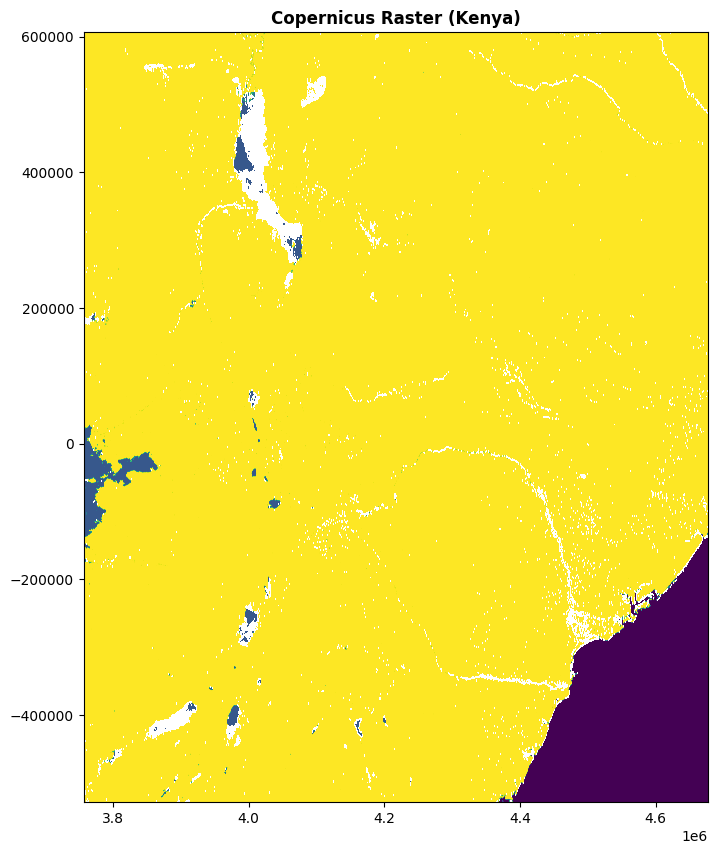

In [95]:
# Open the raster file
with rasterio.open('/mnt/share/homes/mfiking/population/gis/population/test/copernicus_raster_kenya_wb.tif') as src:
    # Read the raster data
    data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(10, 10))
    rasterio.plot.show(data, transform=src.transform, cmap='viridis', title='Copernicus Raster (Kenya)')

    # Show the plot
    plt.show()

## Plot Water (70) #

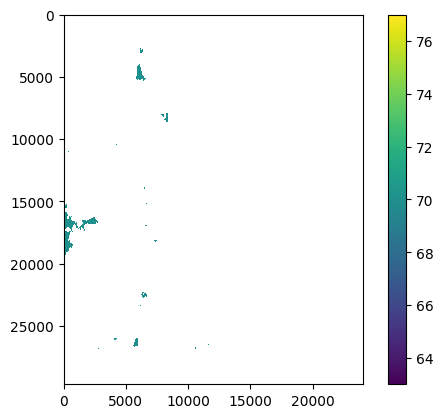

In [96]:
# Open the original raster file
with rasterio.open('/mnt/share/homes/mfiking/population/gis/population/test/copernicus_raster_kenya_wb.tif') as src:
    # Read the raster data as a numpy array
    data2 = src.read(1)

    # Create a mask where values are either 0 or 255
    mask = (data2 == 70)

    # Apply the mask to set non-zero values to nan
    data2[~mask] = np.nan

    # Plot the raster
    plt.imshow(data2, cmap='viridis')
    plt.colorbar()
    plt.show()

# Plot only the Sea (0) and No Water (255) #

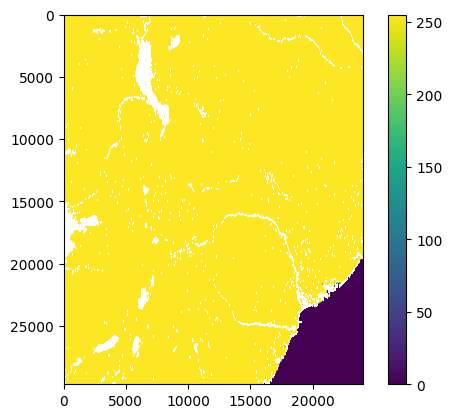

In [97]:
# Open the original raster file
with rasterio.open('/mnt/share/homes/mfiking/population/gis/population/test/copernicus_raster_kenya_wb.tif') as src:
    # Read the raster data as a numpy array
    data2 = src.read(1)

    # Create a mask where values are either 0 or 255
    mask = (data2 == 0) | (data2 == 255)

    # Apply the mask to set non-zero values to nan
    data2[~mask] = np.nan

    # Plot the raster
    plt.imshow(data2, cmap='viridis')
    plt.colorbar()
    plt.show()

In [27]:
np.unique(data2)

array([  0., 255.,  nan], dtype=float32)

In [54]:
data2

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [ nan,  nan,  nan, ...,   0.,   0.,   0.],
       [ nan,  nan,  nan, ...,   0.,   0.,   0.],
       [ nan,  nan,  nan, ...,   0.,   0.,   0.]], dtype=float32)

In [55]:
result_array = np.isnan(data2).astype(int)

In [56]:
result_array = 1 - result_array

In [57]:
result_array

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [90]:
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [85]:
test =  np.isnan(data).astype(int)

In [87]:
test = 1 - test

In [88]:
test

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [89]:
test == result_array

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

## Step Distance Computation ##

In [58]:
%%time
test_out = distance_transform_edt(result_array)

CPU times: user 1min 24s, sys: 9.28 s, total: 1min 33s
Wall time: 1min 33s


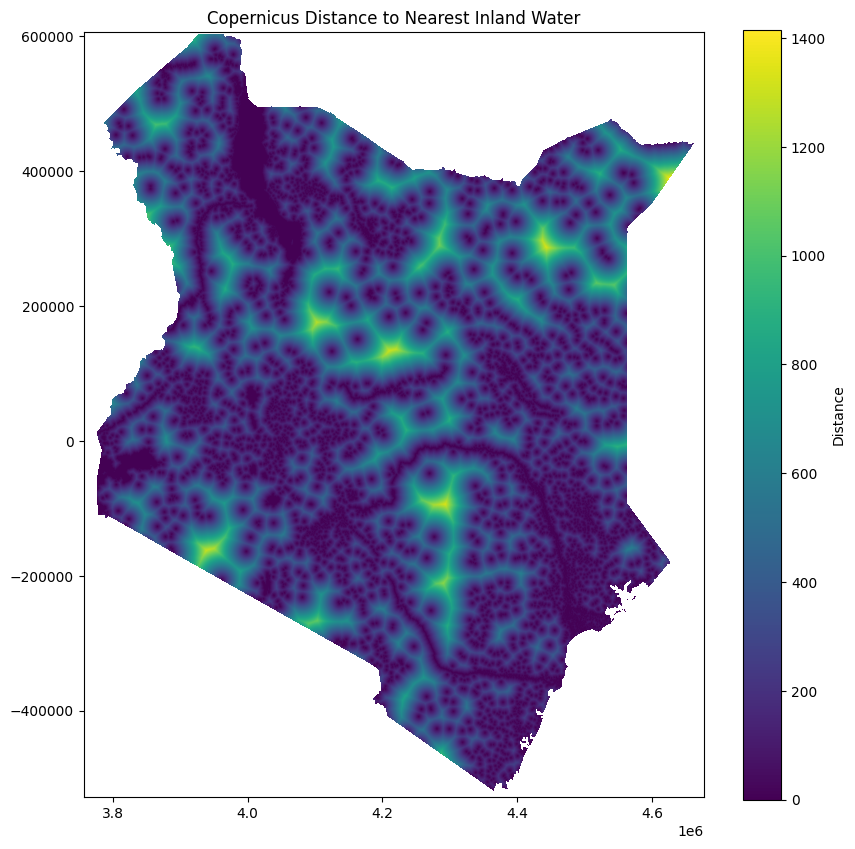

In [59]:
# Use Natural Earth Shape file as place holder
admin0_path = Path('/mnt/share/homes/mfiking/population/gis/population/kenya_admin_files/ken_admbnda_adm0_iebc_20191031.shp')

# Change the data type of the distance array to the same data type as out_meta
test_out = test_out.astype(out_meta['dtype'])

# Create path to store output
test_out_path = '/mnt/share/homes/mfiking/population/gis/population/distance_covariates/copernicus/inland_water_body/inland_water_body.tif'

# Generate meta data into out_path same meta data as out_meta
with rasterio.open(test_out_path, "w", **out_meta) as dest:
    dest.write(test_out.reshape((1, *test_out.shape)))


# Just overwrite the file we wrote
mask_admin(test_out_path, admin0_path, test_out_path)

# Read the combined raster
with rasterio.open(test_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs

# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Distance')

# Set the title of the plot
plt.title('Copernicus Distance to Nearest Inland Water')


plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/copernicus/inland_water_body/plots/inland_water_body.jpg', dpi=300, bbox_inches='tight')

plt.show()


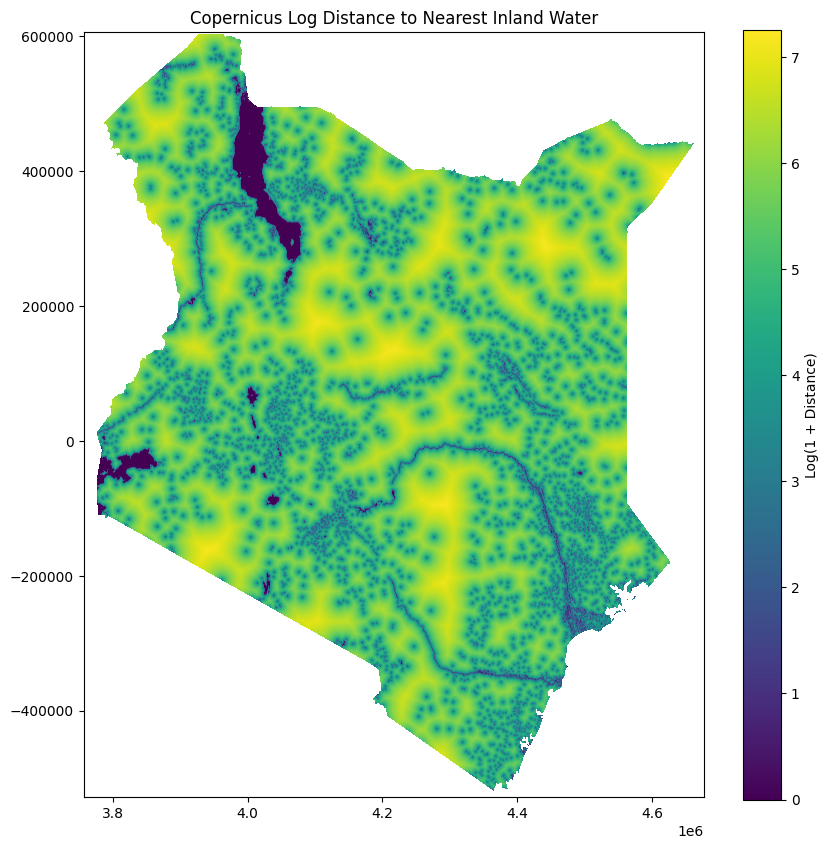

In [60]:
test_out_path = '/mnt/share/homes/mfiking/population/gis/population/distance_covariates/copernicus/inland_water_body/inland_water_body.tif'

# Read the combined raster
with rasterio.open(test_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs
    
    # Apply the log transformation
    combined_raster = np.log(1 + combined_raster)
    
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Log(1 + Distance)')

# Set the title of the plot
plt.title('Copernicus Log Distance to Nearest Inland Water')


plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/copernicus/inland_water_body/plots/log_inland_water_body.jpg', dpi=300, bbox_inches='tight')

plt.show()


# Quality Measurements #

In [61]:
ds = copernicus.copy()

In [62]:
ds

<xarray.Dataset>
Dimensions:  (lat: 168000, lon: 432000, time: 1)
Coordinates:
  * lat      (lat) float64 -60.0 -60.0 -60.0 -60.0 -60.0 ... 80.0 80.0 80.0 80.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2023-09-01
Data variables:
    crs      |S1 ...
    WB       (time, lat, lon) float32 ...
    QUAL     (time, lat, lon) float32 ...
Attributes: (12/26)
    Conventions:                CF-1.5
    GDAL:                       GDAL 3.0.4, released 2020/01/28
    history:                    2023-09-02 Processing line WB100 version 1 us...
    parent_identifier:          urn:cgls:global:wb_v1_100m
    long_name:                  Water Bodies
    copyright:                  Copernicus Service information 2020
    ...                         ...
    purpose:                    This product is first designed to fit the req...
    credit:                     The WB100 product is generated by the Global ...
    gemet_keywords:             water body
    inspire_theme:              Orthoimagery
    gcmd_keywords:              SURFACE WATER
    iso19115_topic_categories:  imageryBaseMapsEarthCover;inlandWaters;enviro...

In [63]:
# Print flag_meanings and flag_values for WB
print("WB:")
print("Flag Meanings:", ds.WB.flag_meanings)
print("Flag Values:", ds.WB.flag_values)
print("\n")

WB:
Flag Meanings: Sea Water No_data No_water
Flag Values: [  0  70 251 255]




In [64]:
# Print flag_meanings and flag_values for QUAL
print("QUAL:")
print("Flag Meanings:", ds.QUAL.flag_meanings)
print("Flag Values:", ds.QUAL.flag_values)

QUAL:
Flag Meanings: Sea Very_low Low Medium High Very_high Permanent No_data Cloud No_water
Flag Values: [  0  71  72  73  74  75  76 251 252 255]


In [66]:
# Extract flag_meanings and flag_values for WB
wb_data = {'Flag Meanings': ds.WB.flag_meanings.split(), 'Flag Values': ds.WB.flag_values.tolist()}

# Extract flag_meanings and flag_values for QUAL
qual_data = {'Flag Meanings': ds.QUAL.flag_meanings.split(), 'Flag Values': ds.QUAL.flag_values.tolist()}

In [75]:
type(wb_data)

dict

In [76]:
# Create DataFrames
wb_df = pd.DataFrame(wb_data, index=pd.Index(['WB'] * len(wb_data['Flag Meanings']), name='Variable'))
qual_df = pd.DataFrame(qual_data, index=pd.Index(['QUAL'] * len(qual_data['Flag Meanings']), name='Variable'))

In [77]:
wb_df

,Flag Meanings,Flag Values
Variable,,
WB,Sea,0
WB,Water,70
WB,No_data,251
WB,No_water,255


In [78]:
qual_df

,Flag Meanings,Flag Values
Variable,,
QUAL,Sea,0
QUAL,Very_low,71
QUAL,Low,72
QUAL,Medium,73
QUAL,High,74
QUAL,Very_high,75
QUAL,Permanent,76
QUAL,No_data,251
QUAL,Cloud,252


In [79]:
# Concatenate DataFrames to create the final table
result_table = pd.concat([wb_df, qual_df])

In [80]:
result_table

,Flag Meanings,Flag Values
Variable,,
WB,Sea,0
WB,Water,70
WB,No_data,251
WB,No_water,255
QUAL,Sea,0
QUAL,Very_low,71
QUAL,Low,72
QUAL,Medium,73
QUAL,High,74


In [100]:
data_qual = copernicus['QUAL'].squeeze()

# Load the admin 0 shapefile for Kenya
kenya_admin0 = gpd.read_file(admin0_path)

kenya_admin0.to_crs(epsg=4326)

# Get the bounding box of Kenya
kenya_bbox = kenya_admin0.total_bounds

kenya_qual = data_qual.sel(lon=slice(kenya_bbox[0], kenya_bbox[2]), lat=slice(kenya_bbox[1], kenya_bbox[3]))

# Get the coordinate arrays from wb_data_kenya
lon = kenya_qual['lon'].values
lat = kenya_qual['lat'].values[::-1]  # Reverse the order of latitude values

# Create a transform using lon and lat arrays
transform = from_origin(lon[0], lat[-1], lon[1] - lon[0], lat[1] - lat[0])

# Create an empty raster
with rasterio.open('/mnt/share/homes/mfiking/population/gis/population/test/copernicus_raster_kenya_qual.tif', 'w', driver='GTiff', width=target_width, height=target_height,
                   count=1, dtype=rasterio.float32, crs='EPSG:3857', transform=target_transform) as dst:
    dst.write(kenya_qual.values[::-1], indexes=1)  # Reverse the data array as well

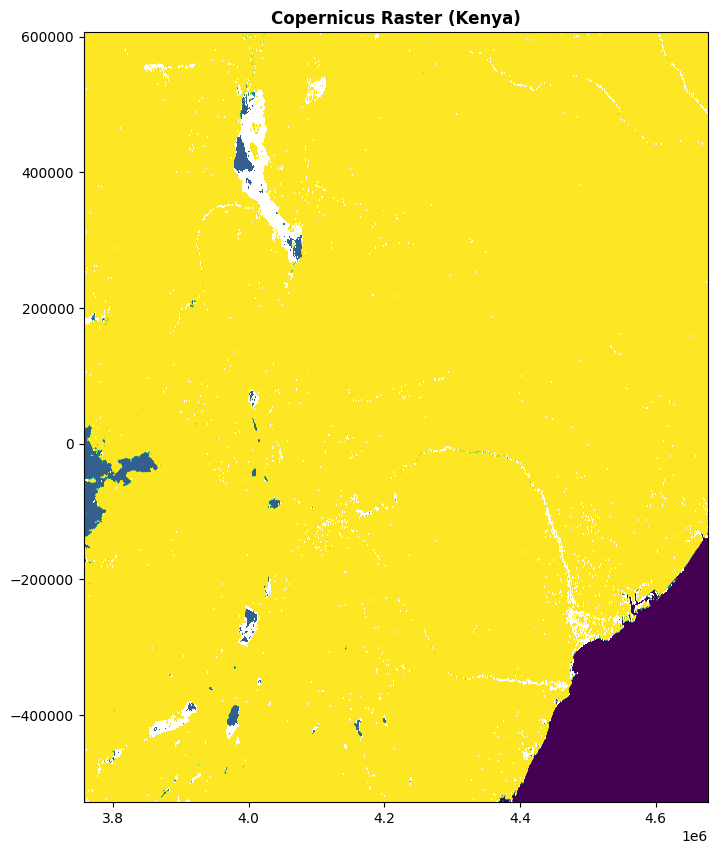

In [111]:
# Open the raster file
with rasterio.open('/mnt/share/homes/mfiking/population/gis/population/test/copernicus_raster_kenya_qual.tif') as src:
    # Read the raster data
    data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(10, 10))
    rasterio.plot.show(data, transform=src.transform, cmap='viridis', title='Copernicus Raster (Kenya)')

    # Show the plot
    plt.show()

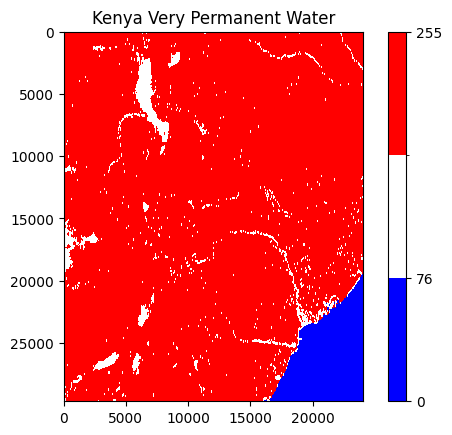

In [123]:
import matplotlib.colors as mcolors
# Open the original raster file
with rasterio.open('/mnt/share/homes/mfiking/population/gis/population/test/copernicus_raster_kenya_qual.tif') as src:
    # Read the raster data as a numpy array
    data2 = src.read(1)

    # Create a mask where values are either 0 or 255 or 71
    mask = (data2 == 0) | (data2 == 255) | (data2 == 76)

    # Apply the mask to set non-zero values to nan
    data2[~mask] = np.nan

    # Create a custom color map
    cmap = mcolors.ListedColormap(['blue', 'white', 'red'])
    bounds = [0, 76, 76.5, 255]  # adjust the boundaries as needed
    norm = mcolors.BoundaryNorm(bounds, cmap.N, clip=True)

    # Plot the raster with the custom color map
    plt.imshow(data2, cmap=cmap, norm=norm)
    
    # Create a custom legend
    plt.colorbar(ticks=[0, 76, 255], boundaries=bounds)
    plt.title('Kenya Very Permanent Water')
    
    plt.show()


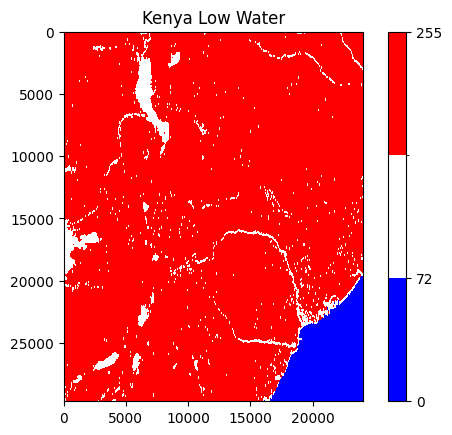

In [114]:
# Open the original raster file
with rasterio.open('/mnt/share/homes/mfiking/population/gis/population/test/copernicus_raster_kenya_qual.tif') as src:
    # Read the raster data as a numpy array
    data2 = src.read(1)

    # Create a mask where values are either 0 or 255 or 71
    mask = (data2 == 0) | (data2 == 255) | (data2 == 72)

    # Apply the mask to set non-zero values to nan
    data2[~mask] = np.nan

    # Create a custom color map
    cmap = mcolors.ListedColormap(['blue', 'white', 'red'])
    bounds = [0, 72, 72.5, 255]  # adjust the boundaries as needed
    norm = mcolors.BoundaryNorm(bounds, cmap.N, clip=True)

    # Plot the raster with the custom color map
    plt.imshow(data2, cmap=cmap, norm=norm)
    
    # Create a custom legend
    plt.colorbar(ticks=[0, 72, 255], boundaries=bounds)
    plt.title('Kenya Low Water')
    
    plt.show()


In [118]:
np.unique(data2)

array([  0.,  72.,  73.,  74.,  75.,  76., 252., 255.,  nan],
      dtype=float32)

In [3]:
# Open the raster file
with rasterio.open('/mnt/share/homes/mfiking/population/gis/population/test/copernicus_raster_kenya_qual.tif') as src:
    # Read the raster data
    data = src.read(1)

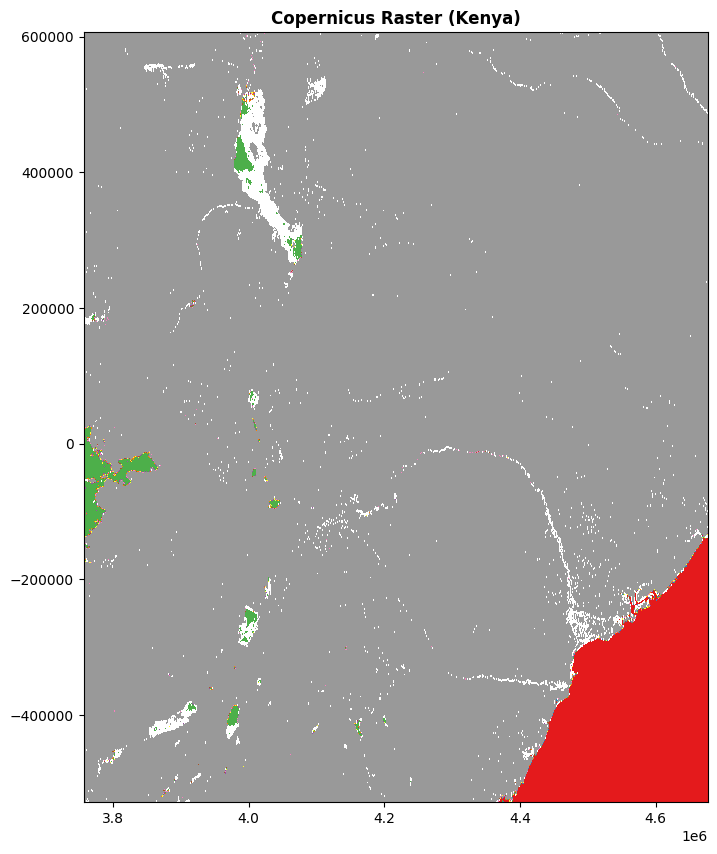

<Figure size 640x480 with 0 Axes>

In [6]:
# Plot the raster data
plt.figure(figsize=(10, 10))
ax = rasterio.plot.show(data, transform=src.transform, cmap='Set1', title='Copernicus Raster (Kenya)')

# Add colorbar
colorbar = plt.colorbar(ax.images[0], ax=ax, fraction=0.03, pad=0.04)  # adjust fraction and pad as needed

# Show the plot
plt.show()